<a href="https://colab.research.google.com/github/snowymo/Colabs/blob/main/AnimateFace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Clone repository**

In [ ]:
!git clone https://github.com/AliaksandrSiarohin/first-order-model

Cloning into 'first-order-model'...
remote: Enumerating objects: 299, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 299 (delta 2), reused 2 (delta 0), pack-reused 293
Receiving objects: 100% (299/299), 72.15 MiB | 32.79 MiB/s, done.
Resolving deltas: 100% (153/153), done.


In [ ]:
cd first-order-model

/content/first-order-model


**Mount your Google drive folder on Colab**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


**Add folder https://drive.google.com/drive/folders/1kZ1gCnpfU0BnpdU47pLM_TQ6RypDDqgw?usp=sharing  to your google drive.
Alternativelly you can use this mirror link https://drive.google.com/drive/folders/16inDpBRPT1UC0YMGMX3dKvRnOUsf5Dhn?usp=sharing**

**Load driving video and source image**

In [ ]:
import imageio, os
import numpy as np
import cv2

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.animation as animation

from skimage.transform import resize
from skimage import img_as_ubyte

from IPython.display import HTML
from google.colab.patches import cv2_imshow

import warnings
warnings.filterwarnings("ignore")

from demo import make_animation, load_checkpoints

# paths to the profile image and the driving video
image_path = '/content/WechatIMG48.jpeg'
driving_video_path = '/content/IMG_1747.mov'

# default path to network weights if you put the pretrained weights on Google Drive
ckpt_path = '/content/gdrive/My Drive/first-order-motion-model/vox-cpk.pth.tar'

# folder to save the output
out_dir = '/content/'
if not os.path.isdir(f'{out_dir}'):
    os.mkdir(f'{out_dir}')
if not os.path.isdir(f'{out_dir}/synthesized_frames/'):
    os.mkdir(f'{out_dir}/synthesized_frames/')

source_image = imageio.imread(f'{image_path}')
reader = imageio.get_reader(f'{driving_video_path}')


In [ ]:
source_image = resize(source_image, (256, 256))[..., :3]

fps = reader.get_meta_data()['fps']
driving_video = []
try:
    for im in reader:
        driving_video.append(im)
except RuntimeError:
    pass
reader.close()

driving_video = [resize(frame, (256, 256))[..., :3] for frame in driving_video]

def display(source, driving, generated=None):
    fig = plt.figure(figsize=(8 + 4 * (generated is not None), 6))

    ims = []
    for i in range(len(driving)):
        cols = [source]
        cols.append(driving[i])
        if generated is not None:
            cols.append(generated[i])
        im = plt.imshow(np.concatenate(cols, axis=1), animated=True)
        plt.axis('off')
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=1000)
    plt.close()
    return ani
    
# Display the profile image and the driving video

HTML(display(source_image, driving_video).to_html5_video())

**Create a model and load checkpoints**

In [ ]:
generator, kp_detector = load_checkpoints(config_path='config/vox-256.yaml', checkpoint_path=f'{ckpt_path}')

**Perform image animation**

In [ ]:
predictions = make_animation(source_image, driving_video, generator, kp_detector, relative=True)

#save resulting video
imageio.mimsave(f'{out_dir}/generated.mp4', [img_as_ubyte(frame) for frame in predictions], fps=fps)

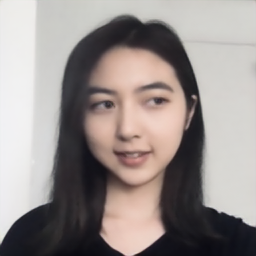

In [ ]:
# each index corresponds to one gaze direction
# it requires finetuning on a different driving video

indices = [220, 229, 241, 245, 249, 266, 268, 270, 272, 279, 
           281, 306, 308, 313, 316, 326, 344, 346, 349, 362]
idx = indices[-1]
im = predictions[idx]
cv2_imshow(cv2.cvtColor(im * 255, cv2.COLOR_RGB2BGR))

In [ ]:
# save the frames
for i, idx in enumerate(indices):
    im = predictions[idx]
    plt.imsave(f'{out_dir}/synthesized_frames/{i}.png', im)